# Real-Time Optimization Tutorial
## Williams-Otto reactor system

In [1]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import logging
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

from rto.models.williams_otto import WilliamsOttoReactor, WilliamsOttoReactorSimplified
from rto.optimization.optimizer import ModelBasedOptimizer
from rto.rto import RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform
from rto.experiment.data_model import RTODataModel
from rto.experiment.analysis import ExperimentAnalyzer


MEMORY_DATABASE = "file::memory:?cache=shared"

## Problem Description
The Williams-Otto CSTR is a benchmark process for real-time optimization (RTO) systems. It consists in the following reactions:

$ A + B \rightarrow C $ (1) 

$ B + C \rightarrow P + E $ (2) 

$ C + P \rightarrow G $ (3) 

where A and B are raw materials, P is the desired product, E is the byproduct with added sales value, C is the complex intermediate without sale value, and G is the residual material. The reactor is fed by two reactant flow rates (Fa and Fb). The full set of mass balance equations can be found in [1], for example.

Each reaction has its rate $k$ defined as a function of the reactor temperature Tr:

$ k_1 = 1.6599\times10^6\exp(-6666.7/Tr) $

$ k_2 = 7.2177\times10^8\exp(-8333.3/Tr) $ 

$ k_3 = 2.6745\times10^{12}\exp(-11111/Tr) $


Fa assumes a fixed, therefore Fb and Tr are our manipulated (decision) variables, $u=[Fb, Tr]$. The optimization objective is finding a combination of these variables in order to maximize the profit when the system reaches steady-state operation:

$ \Phi(u) = 1043.38*Xp*(Fa+Fb)+20.92*Xe*(Fa+Fb) - 79.23*Fa - 118.34*Fb$

where $Xp$ and $Xe$ are the amount of P and E in steady-state operation, respectively. Besides steady-state operation, the following operational constraints are enforced:

$Fb \in [3,6]$

$Tr \in [70, 100]$

$Xa < 0.12$
 
$Xg < 0.08$

In practice, however, it is very unlikely to know the complete model of a given process. It can be in the form of parametrical and/or structural mismatch. Parametrical mismatch means we know the model structure, but its parameters are uncertain. Structural mismatch is the case where we the complete model equations are unknown, which usually happens when trying to model complex processes and have to apply simplifications to some of its behaviors. It is easy to see that if we try to optimize a process based on a uncertain model, we can produce sub-optimal or even unfeasible operating points. This is where RTO systems come to the rescue: they are specifically designed to handle model uncertainty and lead to process optimality under convergence.

For the Williams-Otto CSTR we know all the process equations and parameters. Therefore, to study the real-time optimization capabilities, we will use a simplified version of this model in order to simulate what would happen in real applications. For that, we consider the following model structure:

$ A + 2B \rightarrow P + E $ (1) 

$ A + B + P \rightarrow G $ (2) 

And the reaction rates are given by:

$ k_1 = 1.655\times10^8\exp(-8077.6/Tr) $

$ k_2 = 2.611\times10^{13}\exp(-12438.5/Tr) $ 


## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [3]:
# Our complete model will be called the "plant"
plant = WilliamsOttoReactor()
# And the uncertain is the "model"
model = WilliamsOttoReactorSimplified()

Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

In [4]:
# Define the input domain
grid_size = 50
g0 = 0.12
g1 = 0.08

u1 = np.linspace(3, 6, grid_size)
u2 = np.linspace(70, 100, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g[:,0].reshape(xx.shape)
    zz_g1 = g[:,1].reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

z_plant, g0_plant, g1_plant = get_grid_values(plant, xx, yy)
z_model, g0_model, g1_model = get_grid_values(model, xx, yy)
g_plant = (g1_plant < g1)&(g0_plant < g0)
g_model = (g1_model < g1)&(g0_model < g0)

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

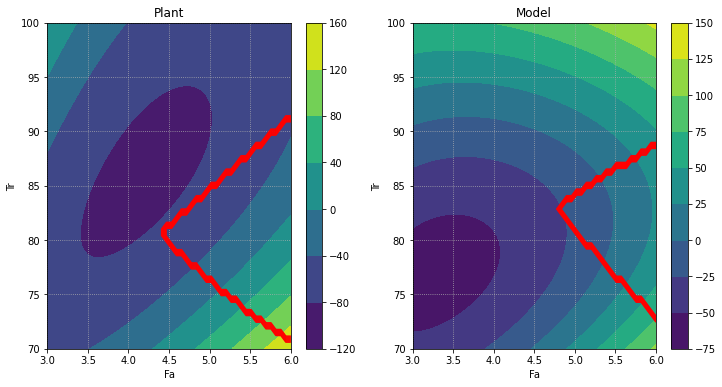

In [5]:
# Plot the decision surface
fig, ax = plt.subplots(1, 2, figsize=(12,6))
def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title):
    ax.contour(xx, yy, z_f, colors='red')
    CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

plot_decision_surface(fig, ax[0], xx, yy, g_plant, z_plant, 'Plant')
plot_decision_surface(fig, ax[1], xx, yy, g_model, z_model, 'Model')
fig.show()

From this chart we notice these interesting information:
1. The unconstrained minima of plant and model and very different. Optimizing over the model would definitely result in a sub-optimal operating point.
2. When constraints are added, the optima are located at their intersection. This could lead to unfeasible operation if optimazing over the model, if not properly evaluated beforehand.

Let's have a deeper look at item (2). In order to do that, we should solve the optimization problem described previously, for both the plant and model. The Differential Evolution algorithm will be used, because of it's nice capabilities for handling restrictions and global convergence.

In [6]:
ubx = [6, 100]
lbx = [3, 70]
g = np.array([g0, g1])

optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin'}})
f_plant, u_plant ,_ = optimizer.run(plant)
f_model, u_model ,_ = optimizer.run(model)

print(f'Plant: u*={u_plant}, f*={f_plant}')
print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[ 4.39024648 80.64055698], f*=-75.7781929967457
Model: u*=[ 4.78854824 83.20941769], f*=-26.167630225792777


Although the solution found for both the model and plant are very close, let's see what happens if we apply the input found with the model into the plant. The 'x' represents the model solution, while the "*" the plant optimum.

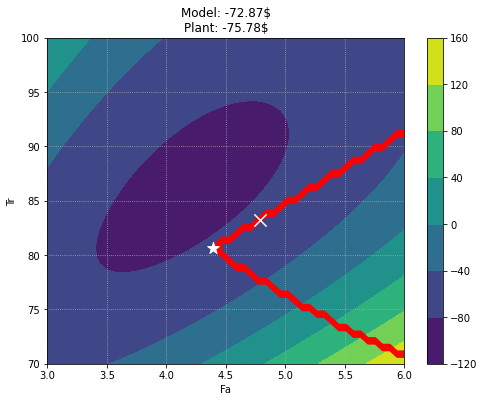

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
model_cost = plant.get_objective(u_model)

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax.scatter(u_model[0], u_model[1], c='w', marker='x', s=150, zorder=5)
fig.show()

Notice that although the solution remained inside the feasible region, it is definitely sub-optimal. It is easy to notice that depending on the model parameters, the optimal solution could easily become unfeasible. Thus, one can see that some sort of adaptation of the model is necessary to ensure convergence to the actual plant optimum, while respecting the process constraints. 

## Real-Time Optimization

RTO systems are capable of iteratively driving the system towards the optimum in spite of plant-model mismatch. The entire system is displayed in the image below:

![RTO System](rto_diagram.png)

Several approaches exist in the literature, and can be classified based on the adaptation strategy they use. The most relevant are the two-step (TS) and modifier adaptation (MA). TS employs as adaptation strategy the update of the model parameters by solving a data reconciliation problem based on measured plant data. On the other hand, modifier adaptation uses plant data to add the so-called modifiers to the cost and constraint functions of the model-based optimization problem. Each method has its pros and cons, and their usage will depend on the process being optimized. 
Here I am going to use first the Modifier Adaptation with Gaussian Processes (GP) scheme.

### Modifier Adaptation with Gaussian Processes
This is a novel technique that leverages GP regression to represent the plant-model mismatch. It removes the need of calculating plant gradients, a requirement for previous MA schemes. The diagram below display how it works in practice:

![MA-GP](rto_magp_diagram.png)

The RTO system is run with the following parameters:
* 5 random feasible sub-optimal operating points
* 30 RTO iterations
* Plant measurements with 1\% additive Gaussian noise
* GP regression:
  * Squared-exponential kernel
  * Trained using the last 10 available operating points
  * New data is only incorporated if sufficiently far from the existing data
* Input exponential filter: $\eta = 0.4$


Since we know the plant's optimal cost and input signal, we can evalute the system performance based on the relative optimality gap:

$\Delta u\% =  \left\|100 \frac{u - u^{opt}}{u^{opt}} \right\|, \quad \Delta \phi \% =  100 \frac{\phi - \phi^{opt}}{\phi^{opt}} $

In [8]:
# creates a memory database to be used in this tutorial
!python create_database.py -m

Created memory database succesfully


Before running the RTO system in closed-loop, first we collect some initialization data. After that, we have to build the two main elements of such system:
* Adaptation Strategy: we use the MA-GP, which is implemented by the `MAGaussianProcesses` class
* Model-based Optimization problem: we need to provide an instance of the `ModelBasedOptimizer` class, using the cost and constraint functions defined in the previous section. Moreover, we must use the approximate model, since in practice we don't know the plant's model.

After that, we pass these objects to the `RTO` class, which will be responsible for running the system in closed loop, as shown in the previous diagrams. Internally, it runs the following steps:

1. Run the model-based optimization problem
2. Filter the calculated optimal input using an exponential filter
3. Apply the input to the plant and collect the necessary measurements
4. Execute the adaptation strategy

All the RTO iteration data is stored in a sqlite database. This makes sure we have everything necessary for analyzing its performance as a whole later. This notebook uses a memory datbase, but one can also use a physical one.

In [9]:
# Define the system parameters
u_0 = u_model
iterations = 30
noise = 0.01
initial_data_size = 5

# sample some initial data
initial_data = generate_samples_uniform(model, plant, g, u_0, initial_data_size, noise=noise)

# create the adaptation strategy
adaptation = MAGaussianProcesses(model, initial_data, filter_data=True, neighbors_type='k_last')
# create the RTO system
rto = RTO(model, plant, optimizer, adaptation, iterations, db_file=MEMORY_DATABASE, name='MA-GP', noise=noise)

/home/victor/git/rto/src/rto/utils.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  meas_initial.append(np.array([fr, gr, fm, gm]))


Finally, we can run the RTO system. The last sampled initial operating point is used to start the system.

In [10]:
u_0_feas = initial_data[0][-1]
rto_id = rto.run(u_0_feas)

After the system stops after reaching the maximum amount of iterations, we can start analyzin the results. In order to do that, we need could use an instance of the `ExperimentAnalyzer` class.

In [11]:
# load the results
analyzer = ExperimentAnalyzer(MEMORY_DATABASE)
results = analyzer.load('MA-GP')
results_processed = analyzer.pre_process(results, f_plant, u_plant)

Below the results for the cost and input optimality gap are displayed. Notice that, although starting from some random initial points, the RTO system was able to drive the process towards plant optimality (0% gap), even though we use an approximate model and measurements are noisy.

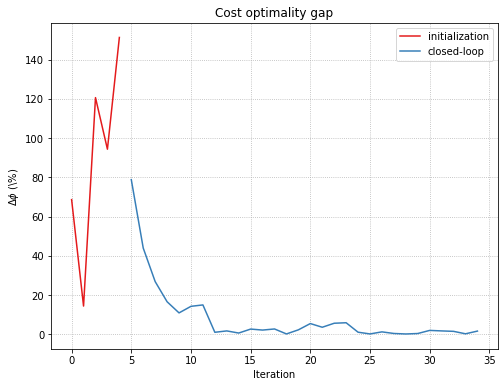

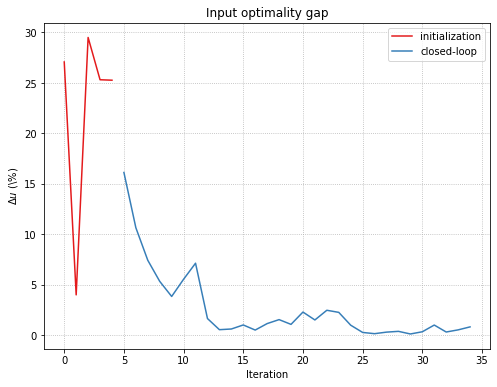

In [12]:
_ = analyzer.plot_by_iteration(results_processed, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap')
_ = analyzer.plot_by_iteration(results_processed, 'du', '$\Delta u$ (\%)', 'Input optimality gap')

It is also possible to look at the operating points calculated at each RTO iteration. The initial dataset is represented by the pink diamonds, while the closed-loop iterations are in black. Notice that the system rapidly converges to the plant optimum, but some of the constratins were violated duting this process. It could be an effect of the measurement noise, as the system also oscilattes around the optimum on convergence.

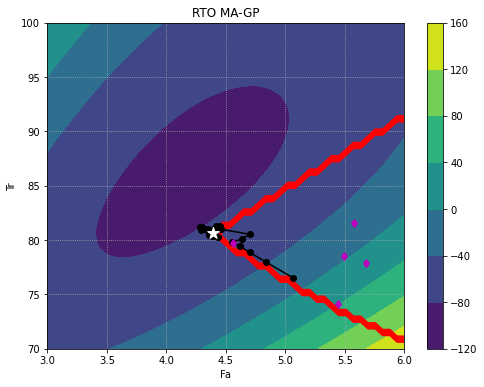

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, 'RTO MA-GP')
u_rto = np.stack(results_processed['u'], axis=0)
u_rto_init = u_rto[:initial_data_size, :]
u_rto = u_rto[initial_data_size:, :]

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax.plot(u_rto[:,0], u_rto[:,1], 'ko-', zorder=4)
ax.plot(u_rto_init[:,0], u_rto_init[:,1], 'md', zorder=4)

fig.show()

## Conclusions

This notebook presented an analysis of the process optimization under uncertainty problem using. By using the Williams-Otto CSTR model, we tackle it using a real-time optimization approach called Modifier Adaptation with Gaussian Process to handle the plant-model mismatch. There are many other aspects of this problem that could be also studied, but they will be analyzed in another opportunity.


## References
1. Zhang, Yale, and J. Fraser Forbes. "Extended design cost: a performance criterion for real-time optimization systems." Computers & Chemical Engineering 24, no. 8 (2000): 1829-1841.
2. de Avila Ferreira, Tafarel, Harsh A. Shukla, Timm Faulwasser, Colin N. Jones, and Dominique Bonvin. "Real-time optimization of uncertain process systems via modifier adaptation and Gaussian processes." In 2018 European Control Conference (ECC), pp. 465-470. IEEE, 2018.